Stepwise Feature Selection and Regression Model Evaluation
This notebook demonstrates Stepwise Forward Selection for feature selection on spectral data and evaluates multiple regression models (PLS, Ridge, Lasso, ElasticNet) on the selected features.

Load and Prepare Data
X: Feature matrix (spectral data)
Y: Target matrix (chemical concentrations)
Reshape Y if it is 1D

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
import warnings

X = np.loadtxt("dataF_final.csv", delimiter=",")
Y = np.loadtxt("dataC_final.csv", delimiter=",")

if Y.ndim == 1:
    Y = Y.reshape(-1, 1)

n_samples, n_features = X.shape
n_targets = Y.shape[1]

scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)


Stepwise Forward Feature Selection
Stepwise selection:
Starts with an empty set of features.
Iteratively adds the feature that gives the best improvement in model performance (lowest RMSE using PLS regression).
Stops when adding a new feature does not improve the RMSE.

In [2]:
def stepwise_forward_selection(X, Y, pls_components=2):
    selected = []
    remaining = list(range(X.shape[1]))
    
    best_rmse = np.inf
    while True:
        rmses = []
        
        for f in remaining:
            features = selected + [f]
            pls = PLSRegression(n_components=min(len(features), pls_components))
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                pls.fit(X[:, features], Y)
            Y_pred = pls.predict(X[:, features])
            rmse = np.sqrt(mean_squared_error(Y, Y_pred))
            rmses.append(rmse)
        
        rmses = np.array(rmses)
        min_idx = np.argmin(rmses)
        
        if rmses[min_idx] >= best_rmse:
            break
        
        best_rmse = rmses[min_idx]
        best_feature = remaining[min_idx]
        selected.append(best_feature)
        remaining.remove(best_feature)
    
    return selected

selected_features = stepwise_forward_selection(X_scaled, Y, pls_components=2)
X_selected = X_scaled[:, selected_features]
print(f"Stepwise selected features ({len(selected_features)}): {selected_features}")


Stepwise selected features (11): [988, 1823, 1041, 1559, 2, 111, 4, 1510, 65, 1551, 1604]


Define Regression Models for Comparison
Models used:
 PLS: Partial Least Squares Regression
 Ridge: L2 Regularization
 Lasso: L1 Regularization
 ElasticNet: Combination of L1 and L2


In [3]:
models = {
    "PLS": PLSRegression(n_components=min(len(selected_features), 5)),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01, max_iter=10000),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5, max_iter=10000)
}


Model Evaluation Function
Calculates:
 R²: Coefficient of determination
 RMSE: Root Mean Square Error
 REP%: Relative Error Percentage
 

In [5]:
def evaluate(model, X_input, Y_true):
    r2_list, rmse_list, rep_list = [], [], []
    for t in range(Y_true.shape[1]):
        y_true = Y_true[:, t]
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            model.fit(X_input, y_true)
        y_pred = model.predict(X_input)
        r2_list.append(r2_score(y_true, y_pred))
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        rmse_list.append(rmse)
        rep_list.append(rmse / np.mean(y_true) * 100)
    return r2_list, rmse_list, rep_list


Evaluate Models on Stepwise-Selected Features

In [6]:
for name, model in models.items():
    r2, rmse, rep = evaluate(model, X_selected, Y)
    print(f"\n{name} on Stepwise-selected features:")
    for i in range(n_targets):
        print(f"Target {i+1}: R²={r2[i]:.4f} | RMSE={rmse[i]:.4f} | REP%={rep[i]:.2f}")



PLS on Stepwise-selected features:
Target 1: R²=0.3853 | RMSE=1474.7890 | REP%=65.13
Target 2: R²=0.4947 | RMSE=2112.1683 | REP%=97.56
Target 3: R²=0.1013 | RMSE=1266.4807 | REP%=198.94
Target 4: R²=0.4423 | RMSE=1870.1691 | REP%=94.78
Target 5: R²=0.0217 | RMSE=1.7865 | REP%=255.13

Ridge on Stepwise-selected features:
Target 1: R²=0.3857 | RMSE=1474.3727 | REP%=65.11
Target 2: R²=0.4949 | RMSE=2111.6206 | REP%=97.53
Target 3: R²=0.1016 | RMSE=1266.2863 | REP%=198.91
Target 4: R²=0.4429 | RMSE=1869.0601 | REP%=94.72
Target 5: R²=0.0218 | RMSE=1.7864 | REP%=255.11

Lasso on Stepwise-selected features:
Target 1: R²=0.3861 | RMSE=1473.8377 | REP%=65.09
Target 2: R²=0.4956 | RMSE=2110.3218 | REP%=97.47
Target 3: R²=0.1017 | RMSE=1266.2044 | REP%=198.89
Target 4: R²=0.4436 | RMSE=1867.9780 | REP%=94.67
Target 5: R²=0.0214 | RMSE=1.7867 | REP%=255.16

ElasticNet on Stepwise-selected features:
Target 1: R²=0.3854 | RMSE=1474.7065 | REP%=65.13
Target 2: R²=0.4945 | RMSE=2112.4301 | REP%=97.5

Visualize Model Performance (R² Comparison)

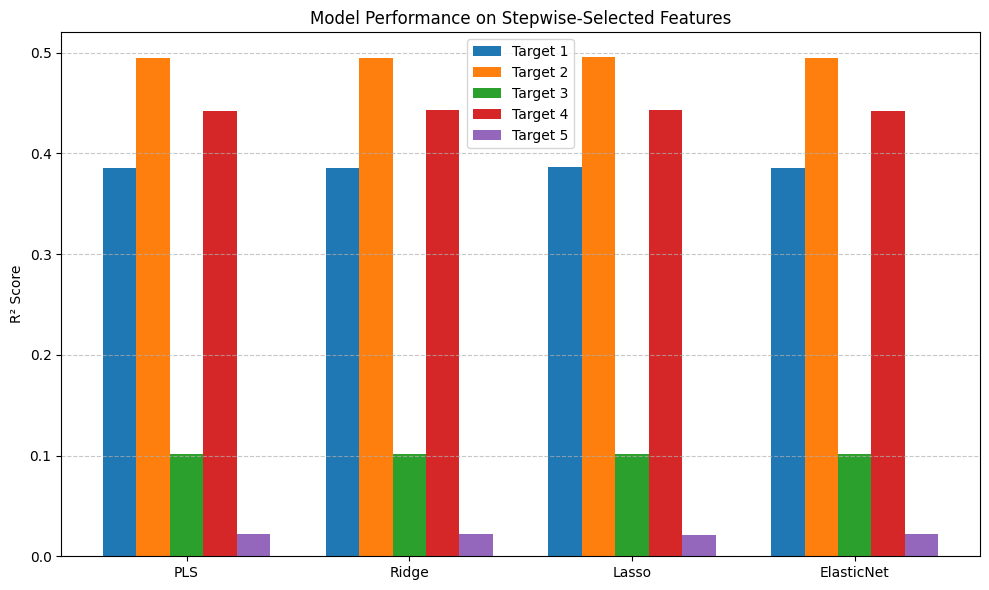

In [7]:
import matplotlib.pyplot as plt
import numpy as np

model_names = []
r2_scores = []


for name, model in models.items():
    r2, rmse, rep = evaluate(model, X_selected, Y)
    model_names.append(name)
    r2_scores.append(r2)

r2_scores = np.array(r2_scores)  

x = np.arange(len(model_names))
width = 0.15

plt.figure(figsize=(10, 6))
for i in range(n_targets):
    plt.bar(x + i*width, r2_scores[:, i], width, label=f"Target {i+1}")

plt.xticks(x + width*(n_targets-1)/2, model_names)
plt.ylabel("R² Score")
plt.title("Model Performance on Stepwise-Selected Features")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()
